<a href="https://colab.research.google.com/github/ericburdett/cs474_labs_f2019/blob/master/DL_Lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 6: Sequence-to-sequence models

## Description:
For this lab, you will code up the [char-rnn model of Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). This is a recurrent neural network that is trained probabilistically on sequences of characters, and that can then be used to sample new sequences that are like the original.

This lab will help you develop several new skills, as well as understand some best practices needed for building large models. In addition, we'll be able to create networks that generate neat text!

## There are two parts of this lab:
###  1.   Wiring up a basic sequence-to-sequence computation graph
###  2.   Implementing your own GRU cell.


An example of my final samples are shown below (more detail in the
final section of this writeup), after 150 passes through the data.
Please generate about 15 samples for each dataset.

<code>
And ifte thin forgision forward thene over up to a fear not your
And freitions, which is great God. Behold these are the loss sub
And ache with the Lord hath bloes, which was done to the holy Gr
And appeicis arm vinimonahites strong in name, to doth piseling 
And miniquithers these words, he commanded order not; neither sa
And min for many would happine even to the earth, to said unto m
And mie first be traditions? Behold, you, because it was a sound
And from tike ended the Lamanites had administered, and I say bi
</code>


---

## Part 0: Readings, data loading, and high level training

---

There is a tutorial here that will help build out scaffolding code, and get an understanding of using sequences in pytorch.

* Read the following

> * [Pytorch sequence-to-sequence tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)
* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)






In [7]:
! wget -O ./text_files.tar.gz 'https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlifkda6h0x5bk%2Fhzosotq4zil49m%2Fjn13x09arfeb%2Ftext_files.tar.gz' 
! tar -xzf text_files.tar.gz
! pip install unidecode
! pip install torch

import unidecode
import string
import random
import re
 
import pdb
 
all_characters = string.printable
n_characters = len(all_characters)
file = unidecode.unidecode(open('./text_files/lotr.txt').read())
file_len = len(file)
print('file_len =', file_len)

shake_file = unidecode.unidecode(open('./text_files/tiny_shakespeare.txt').read())
shake_file_len = len(shake_file)
print('shake_file_len=', shake_file_len)

--2019-10-20 05:56:34--  https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlifkda6h0x5bk%2Fhzosotq4zil49m%2Fjn13x09arfeb%2Ftext_files.tar.gz
Resolving piazza.com (piazza.com)... 3.214.17.10, 52.2.48.133, 34.205.95.128, ...
Connecting to piazza.com (piazza.com)|3.214.17.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://d1b10bmlvqabco.cloudfront.net/attach/jlifkda6h0x5bk/hzosotq4zil49m/jn13x09arfeb/text_files.tar.gz [following]
--2019-10-20 05:56:34--  https://d1b10bmlvqabco.cloudfront.net/attach/jlifkda6h0x5bk/hzosotq4zil49m/jn13x09arfeb/text_files.tar.gz
Resolving d1b10bmlvqabco.cloudfront.net (d1b10bmlvqabco.cloudfront.net)... 13.224.217.42, 13.224.217.34, 13.224.217.219, ...
Connecting to d1b10bmlvqabco.cloudfront.net (d1b10bmlvqabco.cloudfront.net)|13.224.217.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1533290 (1.5M) [application/x-gzip]
Saving to: ‘./text_files.tar.gz’

./text_files.tar.gz 100%[==

In [8]:
chunk_len = 200
 
def random_chunk():
  start_index = random.randint(0, file_len - chunk_len)
  end_index = start_index + chunk_len + 1
  return file[start_index:end_index]

def shake_random_chunk():
  start_index = random.randint(0, shake_file_len - chunk_len)
  end_index = start_index + chunk_len + 1
  return shake_file[start_index:end_index]
  
print(random_chunk())
print(shake_random_chunk())

rom his thin sickly face. For 
a moment he relapsed into his old Gollum-manner. 'We are famisshed, yes 
famisshed we are. precious,' he said. 'What is it they eats? Have they nice 
fisshes? ' His tongu
h. Then all stand still;
On: those that think it is unlawful business
I am about, let them depart.

LEONTES:
Proceed:
No foot shall stir.

PAULINA:
Music, awake her; strike!
'Tis time; descend; be ston


In [9]:
import torch
# Turn string into list of longs
def char_tensor(string):
  tensor = torch.zeros(len(string)).long()
  for c in range(len(string)):
      tensor[c] = all_characters.index(string[c])
  return tensor

print(char_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


---

## Part 4: Creating your own GRU cell 

**(Come back to this later - its defined here so that the GRU will be defined before it is used)**

---

The cell that you used in Part 1 was a pre-defined Pytorch layer. Now, write your own GRU class using the same parameters as the built-in Pytorch class does.

Please try not to look at the GRU cell definition. The answer is right there in the code, and in theory, you could just cut-and-paste it. This bit is on your honor!

**TODO:**

**DONE:**
* Create a custom GRU cell


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Each layer does the following:
# r_t = sigmoid(W_ir*x_t + b_ir + W_hr*h_(t-1) + b_hr)
# z_t = sigmoid(W_iz*x_t + b_iz + W_hz*h_(t-1) + b_hz)
# n_t = tanh(W_in*x_t + b_in + r_t**(W_hn*h_(t-1) + b_hn))
# h_(t) = (1 - z_t)**n_t + z_t**h_(t-1)
# Where ** is hadamard product (not matrix multiplication, but elementwise multiplication)
class GRU(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super(GRU, self).__init__()
    
    self.w_ir = nn.Linear(input_size, hidden_size)
    self.w_hr = nn.Linear(hidden_size, hidden_size)
    self.w_iz = nn.Linear(input_size, hidden_size)
    self.w_hz = nn.Linear(hidden_size, hidden_size)
    self.w_in = nn.Linear(input_size, hidden_size)
    self.w_hn = nn.Linear(hidden_size, hidden_size)
    
    self.sigmoid = nn.Sigmoid()
    self.tanh = nn.Tanh()
  
  def forward(self, inputs, hidden):
    
    r_t = self.sigmoid(self.w_ir(inputs) + self.w_hr(hidden))
    z_t = self.sigmoid(self.w_iz(inputs) + self.w_hz(hidden))
    
    n_t = self.tanh(self.w_in(inputs) + torch.mul(r_t, self.w_hn(hidden)))
    h_t = torch.mul(1 - z_t, n_t) + torch.mul(z_t, hidden)
    
    return h_t[-1:], h_t
  


---

##  Part 1: Building a sequence to sequence model

---

Great! We have the data in a useable form. We can switch out which text file we are reading from, and trying to simulate.

We now want to build out an RNN model, in this section, we will use all built in Pytorch pieces when building our RNN class.


**TODO:**

**DONE:**
* Create an RNN class that extends from nn.Module.


In [0]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, n_layers=1):
    super(RNN, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.n_layers = n_layers
    
    self.embed = nn.Embedding(n_characters, hidden_size)
    self.gru = GRU(input_size=hidden_size, hidden_size=hidden_size, num_layers=n_layers)
    self.relu = nn.ReLU()
    self.linear = nn.Linear(self.hidden_size, self.output_size)
    
    # more stuff here...

  def forward(self, input_char, hidden):
    embedding = self.embed(input_char).unsqueeze(0).unsqueeze(0)
    out_decoded, hidden = self.gru(embedding, hidden)
    linear_out = self.linear(out_decoded)
    output = self.relu(linear_out)

    # by reviewing the documentation, construct a forward function that properly uses the output
    # of the GRU

    # stuff here
    
    return output, hidden

  def init_hidden(self):
    return torch.zeros(self.n_layers, 1, self.hidden_size)

In [0]:
def random_training_set():    
  chunk = random_chunk()
  inp = char_tensor(chunk[:-1])
  target = char_tensor(chunk[1:])
  return inp, target

def shake_random_training_set():
  chunk = shake_random_chunk()
  inp = char_tensor(chunk[:-1])
  target = char_tensor(chunk[1:])
  return inp, target

---

## Part 2: Sample text and Training information

---

We now want to be able to train our network, and sample text after training.

This function outlines how training a sequence style network goes. 

**TODO:**

**DONE:**
* Fill in the pieces.



In [13]:
input_size = n_characters
hidden_size = 200
output_size = n_characters
n_layers = 3
  
decoder = RNN(input_size=input_size, hidden_size=hidden_size,
              output_size=output_size, n_layers=n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-3)
objective = nn.CrossEntropyLoss()

def train(inp, target):
  # initialize hidden state
  hidden = decoder.init_hidden()
  decoder_optimizer.zero_grad()
  
  loss = 0
  
  for char, next_char in zip(inp, target):

    # make prediction, get next hidden state
    pred, hidden = decoder(char, hidden)

    # compute the loss
    loss += objective(pred.squeeze(0), next_char.unsqueeze(0))

  # update the network
  loss.backward()
    
  decoder_optimizer.step()
    
  return loss / len(inp)

Using custom GRU


In [0]:
import gc
gc.collect()

769

---

## Part 3: Sample text and Training information

---

You can at this time, if you choose, also write out your train loop boilerplate that samples random sequences and trains your RNN. This will be helpful to have working before writing your own GRU class.

If you are finished training, or during training, and you want to sample from the network you may consider using the following function. If your RNN model is instantiated as `decoder`then this will probabilistically sample a sequence of length `predict_len`

**TODO:**

**DONE:**
* Fill out the evaluate function to generate text frome a primed string


In [0]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
  ## initialize hidden state, initialize other useful variables
    # your code here
  ## /
  
  with torch.no_grad():
    prime_tensor = char_tensor(prime_str)

    # Priming
    hidden = torch.zeros(n_layers, 1, hidden_size)
    character = char_tensor('')
    for char in prime_tensor:
      character, hidden = decoder(char, hidden)

    probs = F.softmax(character.squeeze(0).squeeze(0) / temperature, dim=0)
    character = torch.multinomial(probs, 1).squeeze(0)

    for _ in range(predict_len):
      character, hidden = decoder(character, hidden)
      probs = F.softmax(character.squeeze(0).squeeze(0) / temperature, dim=0)
      character = torch.multinomial(probs, 1).squeeze(0)
      prime_str += all_characters[character.item()]


  return prime_str.replace('\n', ' ')

---

## Part 4: (Create a GRU cell, requirements above)

---



---

## Part 5: Run it and generate some text!

---

Assuming everything has gone well, you should be able to run the main function in the scaffold code, using either your custom GRU cell or the built in layer, and see output something like this. I trained on the “lotr.txt” dataset, using chunk_length=200, hidden_size=100 for 2000 epochs gave.

**TODO:** 

**DONE:**
* Create some cool output


In [0]:
import time
import gc
n_epochs = 4000
print_every = 100
plot_every = 10
# hidden_size = 200
# n_layers = 3
# lr = 0.001
 
# decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
# decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
# criterion = nn.CrossEntropyLoss()
 
start = time.time()
all_losses = []
loss_avg = 0

In [0]:
for epoch in range(1, n_epochs + 1):
  
  loss_ = train(*random_training_set())       
  loss_avg += loss_

  if epoch % print_every == 0:
    print('[%s (%d %d%%) %.4f]' % (time.time() - start, epoch, epoch / n_epochs * 100, loss_))
    print(evaluate('Wh', 100, .6), '\n')

  if epoch % plot_every == 0:
      all_losses.append(loss_avg / plot_every)
      loss_avg = 0

NameError: ignored

In [0]:
plt.title('Lord of the Rings Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(range(len(all_losses)) * plot_every, all_losses)
plt.show()

In [0]:
for i in range(10):
  start_strings = [" Th", " wh", " he", " I ", " ca", " G", " lo", " ra"]
  start = random.randint(0,len(start_strings)-1)
  print(start_strings[start])
#   all_characters.index(string[c])
  print(evaluate(start_strings[start], 200), '\n')

---

## Part 6: Generate output on a different dataset

---

**TODO:**

**DONE:**

* Choose a textual dataset. Here are some [text datasets](https://www.kaggle.com/datasets?tags=14104-text+data%2C13205-text+mining) from Kaggle 

* Generate some decent looking results and evaluate your model's performance (say what it did well / not so well)

In [16]:
input_size = n_characters
hidden_size = 200
output_size = n_characters
n_layers = 3
  
decoder = RNN(input_size=input_size, hidden_size=hidden_size,
              output_size=output_size, n_layers=n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-3)
objective = nn.CrossEntropyLoss()

shake_start = time.time()
shake_all_losses = []
shake_loss_avg = 0

for epoch in range(1, n_epochs + 1):
  
  shake_loss_ = train(*shake_random_training_set())       
  shake_loss_avg += shake_loss_

  if epoch % print_every == 0:
    print('[%s (%d %d%%) %.4f]' % (time.time() - shake_start, epoch, epoch / n_epochs * 100, shake_loss_))
    print(evaluate('Wh', 100, .6), '\n')

  if epoch % plot_every == 0:
      shake_all_losses.append(shake_loss_avg / plot_every)
      shake_loss_avg = 0

Using custom GRU
[35.80942416191101 (100 2%) 2.4862]
Whd sta, and the that therof pou the cot thats meat the tou thoust the bene me lance pon I int  IBA: 4 

[71.38724660873413 (200 5%) 2.3574]
Whr hen myo loen ano the you in thease be at the me the of he all sho mou saras that in of thou and fo 

[107.32283234596252 (300 7%) 2.1115]
Whn, you and, you that the mose our beestine tor in iso the man the hean the fort thou the for be to l 

[142.74453139305115 (400 10%) 2.0327]
Whd wein to mad of not thou st weat with the dethems the come the thee sir were an the you had soul th 

[178.83712458610535 (500 12%) 2.0804]
Whr the the him.  COLUCELNIO: So comed that you been this the to me hat the dintose the to will for th 

[215.12371921539307 (600 15%) 2.0591]
Wh houl my a your to the dout come and, we the shall day, Thuse hand shtis may of tre, Thet be my dead 

[250.76790189743042 (700 17%) 1.9315]
Wht hath to so kind the hath the rounds the contristances That and that that the dist and an

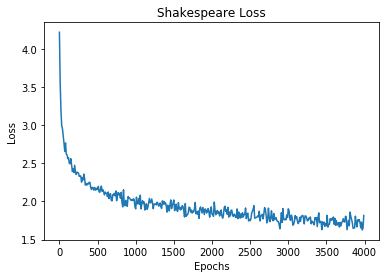

In [23]:
import matplotlib.pyplot as plt

plt.title('Shakespeare Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot([i * plot_every for i in range(len(shake_all_losses))], shake_all_losses)
plt.show()

In [24]:
for i in range(10):
  start_strings = [" Th", " wh", " he", " I ", " ca", " G", " lo", " ra"]
  start = random.randint(0,len(start_strings)-1)
  print(start_strings[start])
#   all_characters.index(string[c])
  print(evaluate(start_strings[start], 200), '\n')

 ca
 canot it to rainst.  HENRY BOLINGART: But to gracious speak her heable me That my lord, I must if it wars nower.  GLOUCESTER: There dound his rest toushal ha/ry semseling him the wear2	ury.  Speen: I sh 

 ca
 cases me goods not our trust Plight and proces and woman to prewour: Thou starible manglosely, but commanged.  RICHARD: No, so set three welkering to pertuches our looks, And her stain, appear to me awe 

 G
 Geil say, consusing of the house 3i"zen, Be made -a world beconsuly to bears as I his beances a sterain.  PETRUCHIO: And your your beding like that Let out, thou is not the miser, And it head, and rung 

 lo
 lok at with Do tone me and you reads, Part thou are your had Grine throw me, when in the wears to make That part to millenderpelity opon The one you do seaten.  LUCIO: The, good blest in to me, appary.  

 ra
 raed to comporign.  PETRUCHIO: I would him is redius do good made To madise and of it instressured This discortal by what would towen your depared That such 

**Evaluation:**

My Model is doing pretty well at organizing general sentence structure. It's even doing fairly well with punctuation. On the shakespeare dataset, it is creating names (in all caps), followed by a colon to denote a person speaking.

Although the model is doing fairly well at creating actual words, including some punctuation